# ChatGPT 4 et les données en format csv (update: 11/05/2023)

Ce notebook reprend la [conversation avec ChatGPT 4 du 10/05/2023](https://github.com/piegu/chatgpt/blob/main/chatGPT4_donnees_csv.ipynb) mais actualize dès le début les formats des colonnes heure afin de pouvoir prendre en compte dans les différents graphiques et instructions la dernière ligne du tableau de données.

## Bibliothèques nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Données dans un DataFrame pandas

**Pierre**: Donne moi le code python du dataframe avec les données entre triple apostrophe en harmonisant les le format des données quand nécessaire.
```
id,client_id,location_id,service_id,jour,heure_début,heure_fin
1,67,22,5,Lundi,08:00,17:00
2,67,22,5,mardi,08:00,17:00
3,23,12,,Mercredi,08:00,17:00
4,19,34,9,Jeudi,08:00,17:00
5,67,22,,vendredi,08:00,17:00
6,0,0,2,Samedi,10:00,18:00
7,0,0,2,dimanche,11:00,17:00
8,,,22,lundi,08:00,12:00
9,,,22,Lundi,14:00,16:00
10,,,22,mercredi,10:00,15h
13,67,22,,Lundi,9h00,03h00
```

D'accord, pour harmoniser vos données, nous aurons besoin de faire plusieurs choses :

- Convertir tous les jours de la semaine en minuscules pour avoir un format uniforme.
- Convertir les heures en format 24h pour plus de cohérence. En supposant que "03h00" après "9h00" signifie "03h00" le lendemain, nous devrons en tenir compte lors de la conversion.

Voici comment vous pouvez le faire en utilisant pandas en Python:

In [36]:
import pandas as pd
from io import StringIO

# Vos données
data = """
id,client_id,location_id,service_id,jour,heure_début,heure_fin
1,67,22,5,Lundi,08:00,17:00
2,67,22,5,mardi,08:00,17:00
3,23,12,,Mercredi,08:00,17:00
4,19,34,9,Jeudi,08:00,17:00
5,67,22,,vendredi,08:00,17:00
6,0,0,2,Samedi,10:00,18:00
7,0,0,2,dimanche,11:00,17:00
8,,,22,lundi,08:00,12:00
9,,,22,Lundi,14:00,16:00
10,,,22,mercredi,10:00,15h
13,67,22,,Lundi,9h00,03h00
"""

# Création du DataFrame
df = pd.read_csv(StringIO(data))

# Conversion des jours en minuscules
df['jour'] = df['jour'].str.lower()

# Conversion des heures en format 24h
df['heure_début'] = df['heure_début'].str.replace('h', ':').str.pad(width=5, side='right', fillchar='0')
df['heure_fin'] = df['heure_fin'].str.replace('h', ':').str.pad(width=5, side='right', fillchar='0')

# Gérer le cas où l'heure de fin est plus tôt que l'heure de début (supposons que cela signifie le jour suivant)
df.loc[df['heure_fin'] < df['heure_début'], 'heure_fin'] = (pd.to_datetime(df['heure_fin']) + pd.DateOffset(days=1)).dt.time.astype(str)

print(df)

    id  client_id  location_id  service_id      jour heure_début heure_fin
0    1       67.0         22.0         5.0     lundi       08:00     17:00
1    2       67.0         22.0         5.0     mardi       08:00     17:00
2    3       23.0         12.0         NaN  mercredi       08:00     17:00
3    4       19.0         34.0         9.0     jeudi       08:00     17:00
4    5       67.0         22.0         NaN  vendredi       08:00     17:00
5    6        0.0          0.0         2.0    samedi       10:00     18:00
6    7        0.0          0.0         2.0  dimanche       11:00     17:00
7    8        NaN          NaN        22.0     lundi       08:00     12:00
8    9        NaN          NaN        22.0     lundi       14:00     16:00
9   10        NaN          NaN        22.0  mercredi       10:00     15:00
10  13       67.0         22.0         NaN     lundi       9:000  03:00:00


Notez que ce code suppose que lorsque l'heure de fin est plus tôt que l'heure de début, cela signifie que l'heure de fin est le jour suivant. Si ce n'est pas le cas dans vos données, vous devrez ajuster le code en conséquence.

**Pierre**: Converti le format des colonnes heure en integer.

D'accord, pour convertir les colonnes des heures en entiers, nous pourrions représenter chaque horaire en nombre total de minutes depuis minuit. Par exemple, 08:00 sera converti en 480 (8 heures * 60 minutes) et 17:00 en 1020 (17 heures * 60 minutes).

Voici comment vous pouvez le faire :

In [39]:
# Conversion des colonnes des heures en entiers (nombre total de minutes depuis minuit)
df['heure_début'] = df['heure_début'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))
df['heure_fin'] = df['heure_fin'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))

print(df)

    id  client_id  location_id  service_id      jour  heure_début  heure_fin
0    1       67.0         22.0         5.0     lundi          480       1020
1    2       67.0         22.0         5.0     mardi          480       1020
2    3       23.0         12.0         NaN  mercredi          480       1020
3    4       19.0         34.0         9.0     jeudi          480       1020
4    5       67.0         22.0         NaN  vendredi          480       1020
5    6        0.0          0.0         2.0    samedi          600       1080
6    7        0.0          0.0         2.0  dimanche          660       1020
7    8        NaN          NaN        22.0     lundi          480        720
8    9        NaN          NaN        22.0     lundi          840        960
9   10        NaN          NaN        22.0  mercredi          600        900
10  13       67.0         22.0         NaN     lundi          540        180


Maintenant, les colonnes 'heure_début' et 'heure_fin' contiennent le nombre total de minutes depuis minuit, ce qui est une représentation entière des heures.

**Pierre**: Ajoute une colonne durée.

Pour ajouter une colonne 'durée', nous allons simplement soustraire 'heure_début' de 'heure_fin'. Cela nous donnera la durée de chaque service en minutes. Si l'heure de fin est avant l'heure de début (comme dans la dernière ligne de vos données), nous ajoutons 24 heures (ou 1440 minutes) à l'heure de fin pour tenir compte du fait que le service se poursuit le jour suivant.

Voici comment vous pouvez le faire :

In [40]:
# Ajout de la colonne durée
df['durée'] = df['heure_fin'] - df['heure_début']
df.loc[df['durée'] < 0, 'durée'] += 24*60  # si l'heure de fin est avant l'heure de début, ajouter 24h

print(df)

    id  client_id  location_id  service_id      jour  heure_début  heure_fin  \
0    1       67.0         22.0         5.0     lundi          480       1020   
1    2       67.0         22.0         5.0     mardi          480       1020   
2    3       23.0         12.0         NaN  mercredi          480       1020   
3    4       19.0         34.0         9.0     jeudi          480       1020   
4    5       67.0         22.0         NaN  vendredi          480       1020   
5    6        0.0          0.0         2.0    samedi          600       1080   
6    7        0.0          0.0         2.0  dimanche          660       1020   
7    8        NaN          NaN        22.0     lundi          480        720   
8    9        NaN          NaN        22.0     lundi          840        960   
9   10        NaN          NaN        22.0  mercredi          600        900   
10  13       67.0         22.0         NaN     lundi          540        180   

    durée  
0     540  
1     540  
2  

Maintenant, le dataframe contient une colonne supplémentaire 'durée' qui indique la durée de chaque service en minutes.

**Pierre**: Convertis les minutes en heures.

Pour convertir les minutes en heures, vous pouvez diviser les valeurs de la colonne 'durée' par 60. Pour avoir un format lisible, vous pouvez utiliser la division entière et le modulo pour obtenir les heures et les minutes séparément.

Voici comment vous pouvez le faire :

In [50]:
# Conversion des minutes en heures et minutes
df['durée'] = df['durée'].apply(lambda x: f"{x // 60}h {x % 60}m")

print(df)

    id  client_id  location_id  service_id      jour heure_début  heure_fin  \
0    1       67.0         22.0         5.0     lundi         NaT       17.0   
1    2       67.0         22.0         5.0     mardi         NaT       17.0   
2    3       23.0         12.0         NaN  mercredi         NaT       17.0   
3    4       19.0         34.0         9.0     jeudi         NaT       17.0   
4    5       67.0         22.0         NaN  vendredi         NaT       17.0   
5    6        0.0          0.0         2.0    samedi         NaT       18.0   
6    7        0.0          0.0         2.0  dimanche         NaT       17.0   
7    8        NaN          NaN        22.0     lundi         NaT       12.0   
8    9        NaN          NaN        22.0     lundi         NaT       16.0   
9   10        NaN          NaN        22.0  mercredi         NaT       15.0   
10  13       67.0         22.0         NaN     lundi         NaT        3.0   

         durée  heure  
0    0.0h 9.0m    NaN  
1  

Maintenant, la colonne 'durée' représente les durées au format "Xh Ym", où X est le nombre d'heures et Y est le nombre de minutes.

**Pierre**: Pas uniquement la colonne durée.

D'accord, si vous voulez convertir toutes les colonnes représentant des durées en minutes en un format "heures:minutes", vous pouvez le faire comme suit :

In [51]:
# Conversion des minutes en heures et minutes pour toutes les colonnes pertinentes
for col in ['heure_début', 'heure_fin', 'durée']:
    df[col] = (df[col] // 60).astype(str) + ':' + (df[col] % 60).astype(str).str.zfill(2)

print(df)

TypeError: ignored

Avec ce code, toutes les colonnes spécifiées qui contiennent des durées en minutes seront converties en un format "heures:minutes". Notez que nous utilisons str.zfill(2) pour nous assurer que les minutes sont toujours représentées par deux chiffres. Par exemple, "8:5" deviendra "8:05".

**Pierre**: Non. Je veux toutes les colonnes en heures de type integer.

D'accord, je comprends maintenant. Vous voulez convertir toutes les colonnes en heures (de type integer), en ignorant les minutes. Vous pouvez le faire en divisant simplement par 60 et en convertissant le résultat en integer.

Voici comment vous pouvez le faire :

In [52]:
# Conversion des minutes en heures (entier) pour toutes les colonnes pertinentes
for col in ['heure_début', 'heure_fin', 'durée']:
    df[col] = (df[col] // 60).astype(int)

print(df)

TypeError: ignored

Maintenant, toutes les colonnes spécifiées représentent des durées en heures entières.

**Pierre**: Donne moi un code global en partant des données initiales jusqu'à ma dernière demande.

D'accord, voici le code complet qui prend en compte toutes les étapes que nous avons décrites précédemment :

In [62]:
import pandas as pd
from io import StringIO

# Vos données
data = """
id,client_id,location_id,service_id,jour,heure_début,heure_fin
1,67,22,5,Lundi,08:00,17:00
2,67,22,5,mardi,08:00,17:00
3,23,12,,Mercredi,08:00,17:00
4,19,34,9,Jeudi,08:00,17:00
5,67,22,,vendredi,08:00,17:00
6,0,0,2,Samedi,10:00,18:00
7,0,0,2,dimanche,11:00,17:00
8,,,22,lundi,08:00,12:00
9,,,22,Lundi,14:00,16:00
10,,,22,mercredi,10:00,15h
13,67,22,,Lundi,9h00,03h00
"""

# Création du DataFrame
df = pd.read_csv(StringIO(data))

# Conversion des jours en minuscules
df['jour'] = df['jour'].str.lower()

# Conversion des heures en format 24h
df['heure_début'] = df['heure_début'].str.replace('h', ':').str.pad(width=5, side='right', fillchar='0')
df['heure_fin'] = df['heure_fin'].str.replace('h', ':').str.pad(width=5, side='right', fillchar='0')

# Gérer le cas où l'heure de fin est plus tôt que l'heure de début (supposons que cela signifie le jour suivant)
df.loc[df['heure_fin'] < df['heure_début'], 'heure_fin'] = (pd.to_datetime(df['heure_fin']) + pd.DateOffset(days=1)).dt.time.astype(str)

# Conversion des colonnes des heures en entiers (nombre total de minutes depuis minuit)
df['heure_début'] = df['heure_début'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))
df['heure_fin'] = df['heure_fin'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))

# Ajout de la colonne durée
df['durée'] = df['heure_fin'] - df['heure_début']
df.loc[df['durée'] < 0, 'durée'] += 24*60  # si l'heure de fin est avant l'heure de début, ajouter 24h

# Conversion des minutes en heures (entier) pour toutes les colonnes pertinentes
for col in ['heure_début', 'heure_fin', 'durée']:
    df[col] = (df[col] // 60).astype(int)

print(df)

    id  client_id  location_id  service_id      jour  heure_début  heure_fin  \
0    1       67.0         22.0         5.0     lundi            8         17   
1    2       67.0         22.0         5.0     mardi            8         17   
2    3       23.0         12.0         NaN  mercredi            8         17   
3    4       19.0         34.0         9.0     jeudi            8         17   
4    5       67.0         22.0         NaN  vendredi            8         17   
5    6        0.0          0.0         2.0    samedi           10         18   
6    7        0.0          0.0         2.0  dimanche           11         17   
7    8        NaN          NaN        22.0     lundi            8         12   
8    9        NaN          NaN        22.0     lundi           14         16   
9   10        NaN          NaN        22.0  mercredi           10         15   
10  13       67.0         22.0         NaN     lundi            9          3   

    durée  
0       9  
1       9  
2  

In [63]:
df

,id,client_id,location_id,service_id,jour,heure_début,heure_fin,durée
0,1,67.0,22.0,5.0,lundi,8,17,9
1,2,67.0,22.0,5.0,mardi,8,17,9
2,3,23.0,12.0,NaN,mercredi,8,17,9
3,4,19.0,34.0,9.0,jeudi,8,17,9
4,5,67.0,22.0,NaN,vendredi,8,17,9
5,6,0.0,0.0,2.0,samedi,10,18,8
6,7,0.0,0.0,2.0,dimanche,11,17,6
7,8,NaN,NaN,22.0,lundi,8,12,4
8,9,NaN,NaN,22.0,lundi,14,16,2
9,10,NaN,NaN,22.0,mercredi,10,15,5


Ce code crée un dataframe à partir de vos données, harmonise les jours et les heures, calcule la durée de chaque service, puis convertit toutes les colonnes d'heures en heures entières.

## Histogramme des jours de la semaine

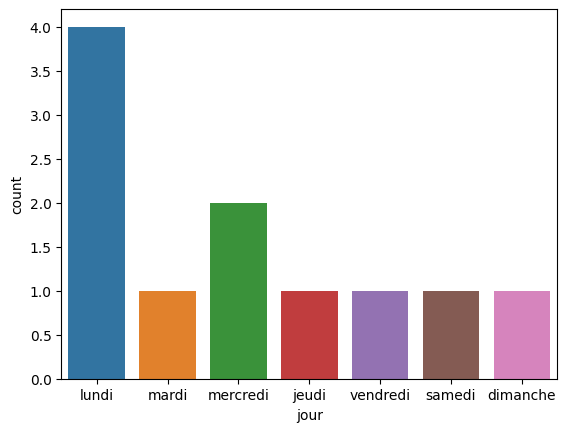

In [64]:
# Mettre les noms des jours de la semaine en minuscules pour l'uniformité
df['jour'] = df['jour'].str.lower()

# Créer un histogramme des jours de la semaine
sns.countplot(data=df, x='jour', order=['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche'])

# Afficher le graphique
plt.show()

## Nombre de services par client

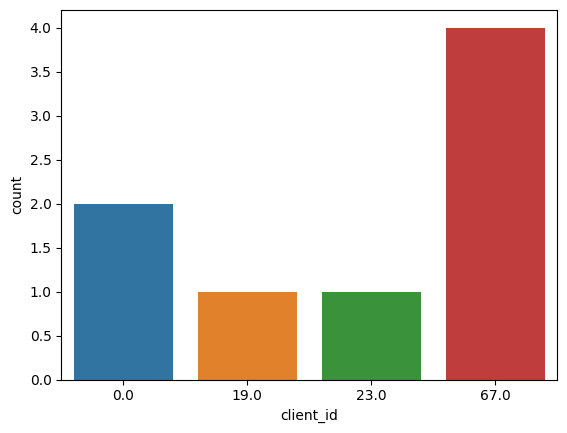

In [66]:
# Créer un histogramme des services par client
sns.countplot(data=df, x='client_id')

# Afficher le graphique
plt.show()

## Nombre de services par emplacement

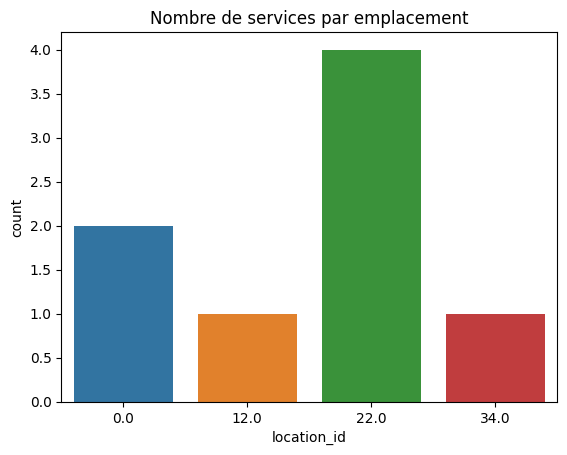

In [68]:
sns.countplot(data=df, x='location_id')
plt.title("Nombre de services par emplacement")
plt.show()

## Répartition des heures de début 

**Pierre**: Créer un histogramme des heures de début

Pour créer un histogramme des heures de début, vous pouvez utiliser la bibliothèque matplotlib, qui est une bibliothèque de visualisation de données couramment utilisée en Python. Voici comment vous pouvez le faire :

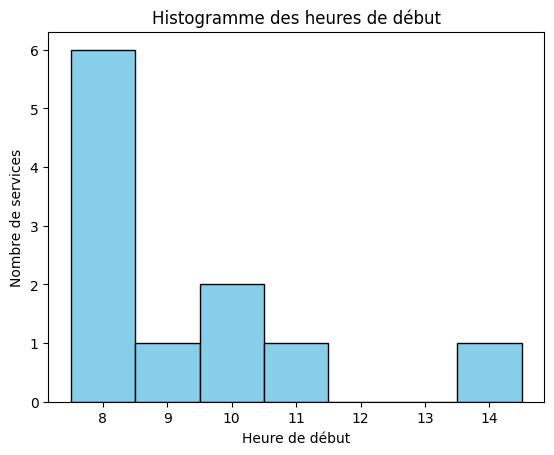

In [73]:
import matplotlib.pyplot as plt

# Création de l'histogramme
plt.hist(df2['heure_début'], bins=range(min(df2['heure_début']), max(df2['heure_début']) + 2), align='left', color='skyblue', edgecolor='black')

plt.title('Histogramme des heures de début')
plt.xlabel('Heure de début')
plt.ylabel('Nombre de services')

plt.show()

Ce code crée un histogramme où chaque barre représente une heure de début différente, et la hauteur de la barre indique le nombre de services qui commencent à cette heure. Le paramètre bins est défini pour s'assurer que chaque heure est représentée par une barre distincte.

## Répartition des services par jour et heure de début

**Pierre**: Créer un tableau croisé dynamique des services par jour et heure de début

Pour créer un tableau croisé dynamique (ou pivot table) des services par jour et heure de début, vous pouvez utiliser la fonction pivot_table de pandas. Voici comment vous pouvez le faire 

In [75]:
# Création du tableau croisé dynamique
pivot_table = df.pivot_table(index='jour', columns='heure_début', values='service_id', aggfunc='count')

# Remplacement des valeurs NaN par 0
pivot_table = pivot_table.fillna(0)

print(pivot_table)

heure_début   8    9    10   11   14
jour                                
dimanche     0.0  0.0  0.0  1.0  0.0
jeudi        1.0  0.0  0.0  0.0  0.0
lundi        2.0  0.0  0.0  0.0  1.0
mardi        1.0  0.0  0.0  0.0  0.0
mercredi     0.0  0.0  1.0  0.0  0.0
samedi       0.0  0.0  1.0  0.0  0.0
vendredi     0.0  0.0  0.0  0.0  0.0


Ce code crée un tableau où les lignes représentent les jours de la semaine et les colonnes représentent les heures de début. Chaque cellule du tableau indique le nombre de services qui commencent à une certaine heure un certain jour.

Notez que nous utilisons fillna(0) pour remplacer les valeurs NaN par 0, car NaN signifie qu'il n'y a pas de services qui commencent à une certaine heure un certain jour.

**Pierre**: Corrige le code précédent avec sns.heatmap.

D'accord, si vous voulez visualiser le tableau croisé dynamique sous forme de carte de chaleur (heatmap) en utilisant la bibliothèque seaborn, vous pouvez le faire comme suit :

In [78]:
df

,id,client_id,location_id,service_id,jour,heure_début,heure_fin,durée
0,1,67.0,22.0,5.0,lundi,8,17,9
1,2,67.0,22.0,5.0,mardi,8,17,9
2,3,23.0,12.0,NaN,mercredi,8,17,9
3,4,19.0,34.0,9.0,jeudi,8,17,9
4,5,67.0,22.0,NaN,vendredi,8,17,9
5,6,0.0,0.0,2.0,samedi,10,18,8
6,7,0.0,0.0,2.0,dimanche,11,17,6
7,8,NaN,NaN,22.0,lundi,8,12,4
8,9,NaN,NaN,22.0,lundi,14,16,2
9,10,NaN,NaN,22.0,mercredi,10,15,5


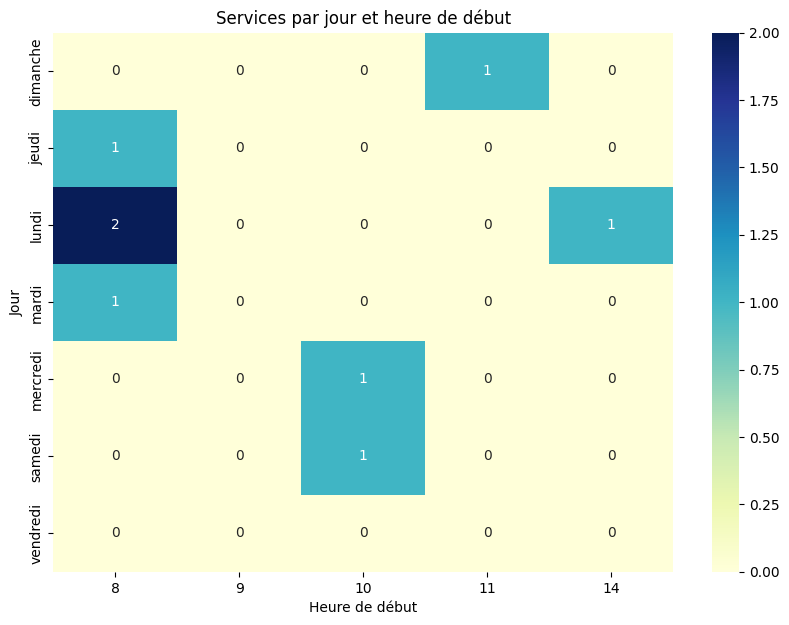

In [77]:
import seaborn as sns

# Création du tableau croisé dynamique
pivot_table = df.pivot_table(index='jour', columns='heure_début', values='service_id', aggfunc='count')

# Remplacement des valeurs NaN par 0
pivot_table = pivot_table.fillna(0)

# Création de la carte de chaleur
plt.figure(figsize=(10, 7))  # définit la taille de la figure
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f")

plt.title('Services par jour et heure de début')
plt.xlabel('Heure de début')
plt.ylabel('Jour')

plt.show()

Ce code crée une carte de chaleur où les lignes représentent les jours de la semaine et les colonnes représentent les heures de début. La couleur de chaque cellule indique le nombre de services qui commencent à une certaine heure un certain jour. Les valeurs sont également annotées sur la carte pour une meilleure lisibilité.

**Pierre**: Modifie dans le code précédent le cmap par coolwarm.

D'accord, pour changer la palette de couleurs de la carte de chaleur à 'coolwarm', vous pouvez simplement modifier le paramètre cmap dans la fonction sns.heatmap. Voici comment vous pouvez le faire :

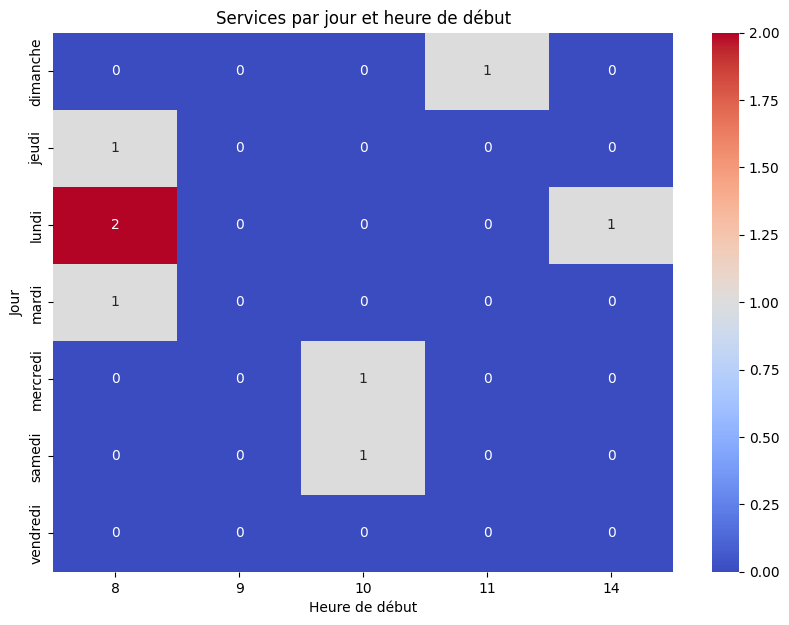

In [79]:
# Création du tableau croisé dynamique
pivot_table = df.pivot_table(index='jour', columns='heure_début', values='service_id', aggfunc='count')

# Remplacement des valeurs NaN par 0
pivot_table = pivot_table.fillna(0)

# Création de la carte de chaleur
plt.figure(figsize=(10, 7))  # définit la taille de la figure
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f")

plt.title('Services par jour et heure de début')
plt.xlabel('Heure de début')
plt.ylabel('Jour')

plt.show()

Maintenant, la carte de chaleur utilise la palette de couleurs 'coolwarm', qui varie du bleu (valeurs faibles) au rouge (valeurs élevées).

## Durée des services

**Pierre**: Créer un histogramme des durées de service

Pour créer un histogramme des durées de service, vous pouvez utiliser la fonction hist de matplotlib.pyplot, similairement à ce que nous avons fait pour l'heure de début. Voici comment vous pouvez le faire :

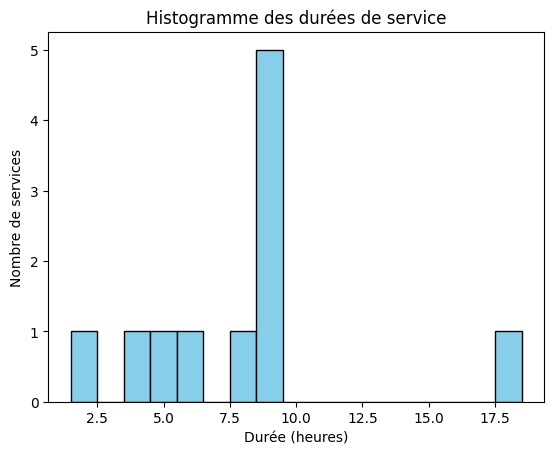

In [81]:
# Création de l'histogramme
plt.hist(df['durée'], bins=range(min(df['durée']), max(df['durée']) + 2), align='left', color='skyblue', edgecolor='black')

plt.title('Histogramme des durées de service')
plt.xlabel('Durée (heures)')
plt.ylabel('Nombre de services')

plt.show()

Ce code crée un histogramme où chaque barre représente une durée de service différente (en heures), et la hauteur de la barre indique le nombre de services de cette durée. Le paramètre bins est défini pour s'assurer que chaque durée est représentée par une barre distincte.

## Nombre d'heures travaillées pour le client 67

**Pierre**: Quel est le nombre d'heures travaillées pour le client 67?

Pour trouver le nombre total d'heures travaillées pour le client 67, vous pouvez filtrer le dataframe pour ne garder que les lignes concernant ce client, puis sommer la colonne 'durée'. Voici comment vous pouvez le faire :

In [85]:
# Filtrage du dataframe pour le client 67
df_client_67 = df[df['client_id'] == '67.']

# Calcul du total des heures travaillées
total_heures = df_client_67['durée'].sum()

print(f"Le nombre total d'heures travaillées pour le client 67 est de {total_heures} heures.")

Le nombre total d'heures travaillées pour le client 67 est de 0 heures.


**Pierre**: Erreur, la colonne client_id est de type float. Recommence.

Je m'excuse pour cette erreur. En effet, le type de la colonne client_id est float. Lors de la comparaison, nous devons donc utiliser le nombre 67 (sans les guillemets). Voici le code corrigé :

In [91]:
# Filtrage du dataframe pour le client 67
df_client_67 = df[df['client_id'] == 67.0]

# Calcul du total des heures travaillées
total_heures = df_client_67['durée'].sum()

print(f"Le nombre total d'heures travaillées pour le client 67 est de {total_heures} heures.")

Le nombre total d'heures travaillées pour le client 67 est de 45 heures.


Ce code crée un nouveau dataframe contenant uniquement les services pour le client 67, puis calcule la somme de la colonne 'durée' de ce dataframe pour obtenir le nombre total d'heures travaillées pour ce client.

## Facturation mensuelle par extrapolation

**Pierre**: Ce tableau de données corresponde à 2 semaines de travail. Le taux horaire est de 120 euros. Calcule la facturation mensuelle en extrapolant ces données, puis donne moi le code de la visualization de cette facturation par jour sur un mois.

Pour extrapoler ces données à un mois, nous devons d'abord calculer le nombre total d'heures travaillées sur les deux semaines, puis multiplier ce nombre par le taux horaire pour obtenir la facturation pour deux semaines. Nous pouvons ensuite multiplier ce montant par 2 pour obtenir la facturation mensuelle.

Pour visualiser la facturation par jour sur un mois, nous pouvons créer un dataframe qui contient la facturation pour chaque jour des deux semaines, puis répéter ce dataframe pour couvrir un mois entier.

Voici comment vous pouvez le faire :

La facturation mensuelle pour le client 67 est de 10800 euros.


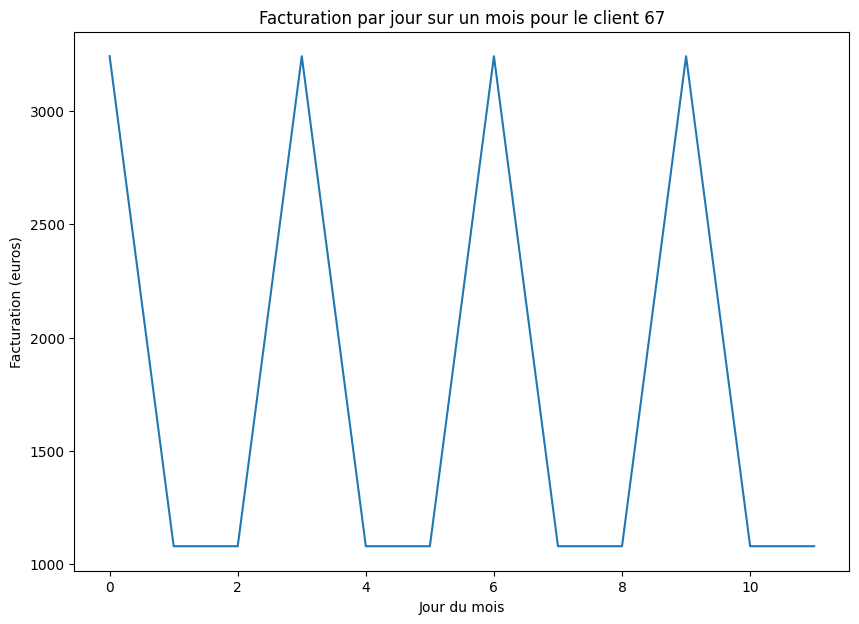

In [92]:
# Calcul de la facturation pour deux semaines
facturation_deux_semaines = total_heures * 120

# Extrapolation à un mois
facturation_mensuelle = facturation_deux_semaines * 2

print(f"La facturation mensuelle pour le client 67 est de {facturation_mensuelle} euros.")

# Création d'un dataframe pour la facturation par jour
df_facturation_par_jour = df[df['client_id'] == 67.0].groupby('jour')['durée'].sum().reset_index()
df_facturation_par_jour['facturation'] = df_facturation_par_jour['durée'] * 120

# Répétition du dataframe pour couvrir un mois entier
df_facturation_par_jour = pd.concat([df_facturation_par_jour]*4, ignore_index=True)

# Création du graphique de la facturation par jour sur un mois
plt.figure(figsize=(10, 7))
sns.lineplot(data=df_facturation_par_jour, x=range(len(df_facturation_par_jour)), y='facturation')

plt.title('Facturation par jour sur un mois pour le client 67')
plt.xlabel('Jour du mois')
plt.ylabel('Facturation (euros)')

plt.show()

Ce code calcule d'abord la facturation mensuelle pour le client 67, puis crée un dataframe qui contient la facturation pour chaque jour des deux semaines. Ce dataframe est ensuite répété pour couvrir un mois entier. Enfin, un graphique de la facturation par jour sur un mois est créé.

**Pierre**: Je veux cette visualization en tenant compte de tous les clients. Je veux une seule courbe.

Pour visualiser la facturation pour tous les clients, nous devons d'abord calculer la facturation pour chaque jour pour tous les clients. Ensuite, nous pouvons créer un graphique qui montre cette facturation cumulée par jour pour un mois entier. Voici comment vous pouvez faire cela :

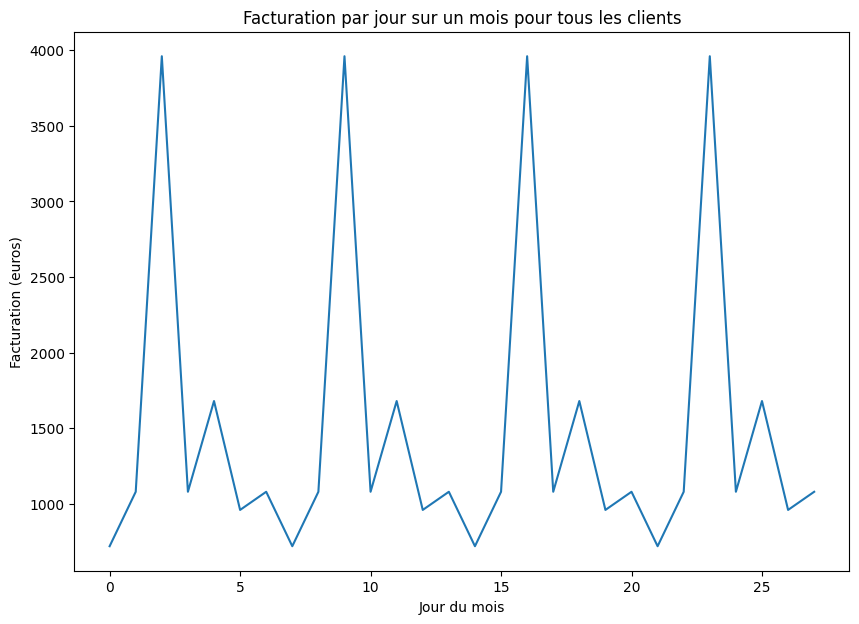

In [93]:
# Calcul de la facturation pour chaque jour pour tous les clients
df_facturation_par_jour = df.groupby('jour')['durée'].sum().reset_index()
df_facturation_par_jour['facturation'] = df_facturation_par_jour['durée'] * 120

# Répétition du dataframe pour couvrir un mois entier
df_facturation_par_jour = pd.concat([df_facturation_par_jour]*4, ignore_index=True)

# Création du graphique de la facturation par jour sur un mois pour tous les clients
plt.figure(figsize=(10, 7))
sns.lineplot(data=df_facturation_par_jour, x=range(len(df_facturation_par_jour)), y='facturation')

plt.title('Facturation par jour sur un mois pour tous les clients')
plt.xlabel('Jour du mois')
plt.ylabel('Facturation (euros)')

plt.show()

In [94]:
df_facturation_par_jour

,jour,durée,facturation
0,dimanche,6,720
1,jeudi,9,1080
2,lundi,33,3960
3,mardi,9,1080
4,mercredi,14,1680
5,samedi,8,960
6,vendredi,9,1080
7,dimanche,6,720
8,jeudi,9,1080
9,lundi,33,3960


Ce code crée un nouveau dataframe qui contient la facturation pour chaque jour pour tous les clients. Ce dataframe est ensuite répété pour couvrir un mois entier. Enfin, un graphique de la facturation cumulée par jour sur un mois est créé.

**Pierre**: Donne moi la visualization de la facturation cumulée par jour sur 1 mois.

Pour visualiser la facturation cumulée par jour sur un mois, nous pouvons utiliser la méthode cumsum() pour calculer la somme cumulative de la facturation chaque jour. Voici comment vous pouvez le faire :

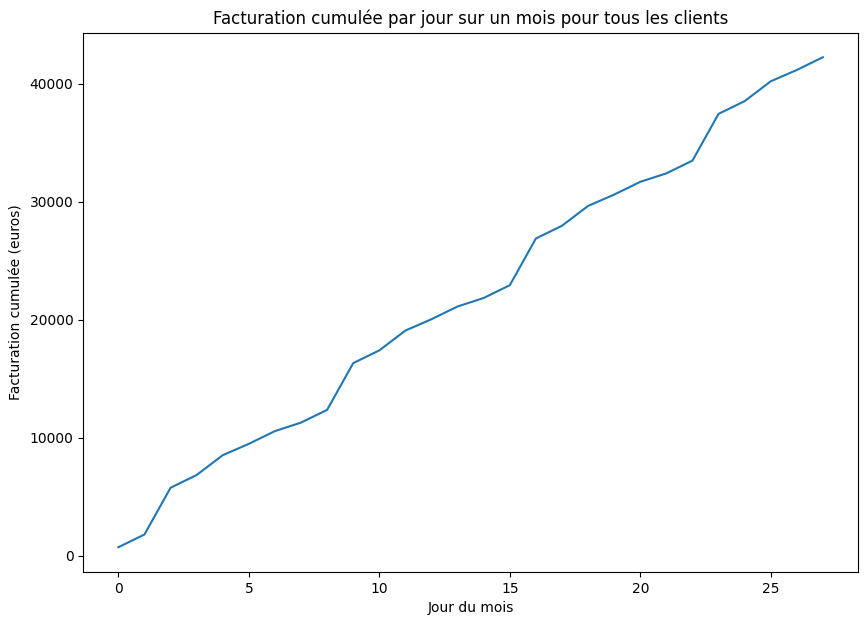

In [95]:
# Calcul de la facturation pour chaque jour pour tous les clients
df_facturation_par_jour = df.groupby('jour')['durée'].sum().reset_index()
df_facturation_par_jour['facturation'] = df_facturation_par_jour['durée'] * 120

# Répétition du dataframe pour couvrir un mois entier
df_facturation_par_jour = pd.concat([df_facturation_par_jour]*4, ignore_index=True)

# Calcul de la facturation cumulée
df_facturation_par_jour['facturation_cumulée'] = df_facturation_par_jour['facturation'].cumsum()

# Création du graphique de la facturation cumulée par jour sur un mois pour tous les clients
plt.figure(figsize=(10, 7))
sns.lineplot(data=df_facturation_par_jour, x=range(len(df_facturation_par_jour)), y='facturation_cumulée')

plt.title('Facturation cumulée par jour sur un mois pour tous les clients')
plt.xlabel('Jour du mois')
plt.ylabel('Facturation cumulée (euros)')

plt.show()

Ce code crée d'abord un nouveau dataframe qui contient la facturation pour chaque jour pour tous les clients. Ce dataframe est ensuite répété pour couvrir un mois entier. La méthode cumsum() est utilisée pour calculer la facturation cumulée chaque jour. Enfin, un graphique de la facturation cumulée par jour sur un mois est créé.

**Pierre**: Merci. Tu es un bon assistant.

Je vous remercie pour vos aimables paroles ! Je suis ici pour vous aider. N'hésitez pas si vous avez d'autres questions ou besoin d'assistance supplémentaire.